## Key Requirements for the iRF scikit-learn implementation

* The following is a documentation of the main requirements for the iRF implementation

## Typical Setup

In [ ]:
# Setup
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn import tree
import numpy as np

# Define a function to draw the decision trees in IPython
# Adapted from: http://scikit-learn.org/stable/modules/tree.html
from IPython.display import display, Image
import pydotplus

# Custom util functions
from utils import utils

RANDOM_STATE_SPLIT         = 1001
RANDOM_STATE_CLASSIFIER    = 1039

## Step 1: Fit the Initial Random Forest

* Just fit every feature with equal weights per the usual random forest code e.g. DecisionForestClassifier in scikit-learn

In [2]:
# Load the iris data
iris = load_iris()

# Create the train-test datasets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = RANDOM_STATE_SPLIT)

# Just fit a simple random forest classifier with 2 decision trees
rf = RandomForestClassifier(n_estimators = 2, random_state = RANDOM_STATE_CLASSIFIER)
rf.fit(X = X_train, y = y_train)

# Now plot the trees individually
#for idx, dtree in enumerate(rf.estimators_):
#    print(idx)
#    utils.draw_tree(inp_tree = dtree)

### Check that we can store objects of different types in a dictionary

* This includes storing the random forest object under one key and also a simple numerial value in another key

In [3]:
a = 1
test = {} # create the dictionary to store the objects
test['first']  = a
test['rf_obj'] = rf

In [4]:
print(test['first'])
print(test['rf_obj'].feature_importances_)

1
[ 0.01917201  0.02837771  0.32183984  0.63061044]


**Yay - seems to work just fine!**

## Step 2: Get the Gini Importance of Weights

* For the first random forest we just need to get the Gini Importance of Weights

### Step 2.1 Get them numerically - most important

In [5]:
importances = rf.feature_importances_
std = np.std([dtree.feature_importances_ for dtree in rf.estimators_]
             , axis=0)
indices = np.argsort(importances)[::-1]

# Check that the feature importances are standardized to 1
print(sum(importances))

1.0


### Step 2.2 Display Feature Importances Graphically (just for interest)

Feature ranking:
1. feature 3 (0.630610)
2. feature 2 (0.321840)
3. feature 1 (0.028378)
4. feature 0 (0.019172)


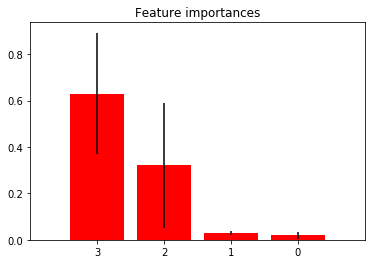

In [6]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Step 3: For each Tree get core leaf node features

* For each decision tree in the classifier, get:
    * The list of leaf nodes
    * Depth of the leaf node    
    * Leaf node predicted class i.e. {0, 1}
    * Probability of predicting class in leaf node
    * Number of observations in the leaf node i.e. weight of node

### Name the Features

In [7]:
feature_names = ["X" + str(i) for i in range(X_train.shape[1])]
target_vals = list(np.sort(np.unique(y_train)))
target_names = ["y" + str(i) for i in target_vals]
print(feature_names)
print(target_names)

['X0', 'X1', 'X2', 'X3']
['y0', 'y1', 'y2']


### Get the second Decision tree to use for testing

In [8]:
estimator = rf.estimators_[1]

In [9]:
from sklearn.tree import _tree
estimator.tree_.children_left[0]
estimator.tree_.children_right[0]

2

### Write down an efficient Binary Tree Traversal Function

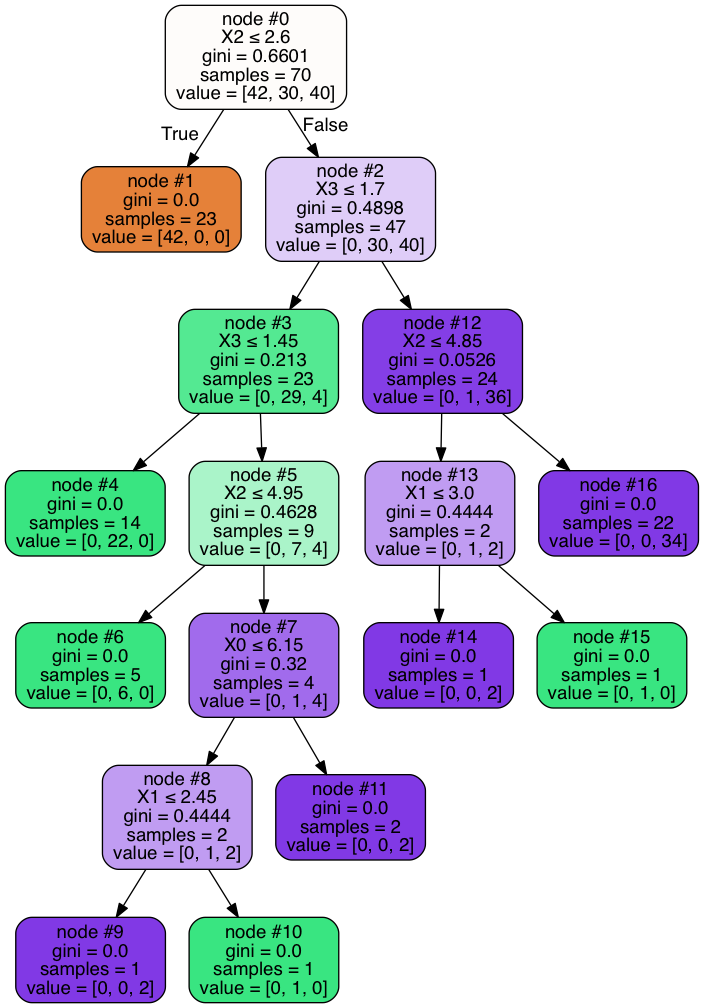

In [10]:
# Now plot the trees individually
utils.draw_tree(inp_tree = estimator)

### Create the single function to output the required values

We have the following **inputs**:
* Decision Tree Classifier from the Random Forest Classifier
* Root node id = 0 (should be the default and only value passed in here)

We have the following **outputs**:
* Leaf node paths in order
* Max node depth
* Leaf node predicted class {0, 1}
* Total leaf node samples
* Leaf node class sample sizes
* Leaf node class sample proportions
* Unordered boolean features

In [11]:
# Setup the key variables
threshold       = estimator.tree_.threshold

In [12]:
max_node_depth = estimator.tree_.max_depth
max_node_depth
print("Max node depth in tree", max_node_depth, sep = ":\n")

Max node depth in tree:
6


In [13]:
n_nodes         = estimator.tree_.node_count
print("number of nodes in tree", n_nodes, sep = ":\n")

number of nodes in tree:
17


In [41]:
# Define the number of features
num_features = X_train.shape[1]

# Get the node features from the decision tree classifier attribute
# It is hard to tell which features this came from i.e. indices are zero,
# positive and negative - we want only non-negative indices for the 
# corresponding feature columns
node_features   = estimator.tree_.feature

# Get indices for all the features used - 0 indexed and ranging
# to the total number of possible features in the training data
all_features_idx = np.array(range(num_features))

node_features_idx = np.array(range(num_features))[node_features]

# Count the unique number of features used
num_features_used = (np.unique(node_features_idx)).shape[0]

print("number of node features", num_features_used, sep = ":\n")
print("all features indices", all_features_idx, sep = ":\n")
print("node features", node_features, sep = ":\n")
print("node feature indices", node_features_idx, sep = ":\n")

number of node features:
4
all features indices:
[0 1 2 3]
node features:
[ 2 -2  3  3 -2  2 -2  0  1 -2 -2 -2  2  1 -2 -2 -2]
node feature indices:
[2 2 3 3 2 2 2 0 1 2 2 2 2 1 2 2 2]


In [15]:
def allTreePaths(dtree, root_node_id = 0):
    """Get all the individual tree paths from root node 
       to the leaves
    """
    # Use these lists to parse the tree structure
    children_left  = dtree.tree_.children_left
    children_right = dtree.tree_.children_right

    if root_node_id is None: 
        paths      = []
    
    if root_node_id == _tree.TREE_LEAF:
        raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)
        
    # if left/right is None we'll get empty list anyway
    if children_left[root_node_id] != _tree.TREE_LEAF:
        paths = [np.append(root_node_id, l)
                 for l in allTreePaths(dtree, children_left[root_node_id]) + 
                          allTreePaths(dtree, children_right[root_node_id])]

    else:
        paths = [root_node_id]
    
    return paths

In [16]:
all_leaf_node_paths = allTreePaths(rf.estimators_[1], root_node_id = 0)
all_leaf_node_paths

[array([0, 1]),
 array([0, 2, 3, 4]),
 array([0, 2, 3, 5, 6]),
 array([0, 2, 3, 5, 7, 8, 9]),
 array([ 0,  2,  3,  5,  7,  8, 10]),
 array([ 0,  2,  3,  5,  7, 11]),
 array([ 0,  2, 12, 13, 14]),
 array([ 0,  2, 12, 13, 15]),
 array([ 0,  2, 12, 16])]

In [17]:
leaf_nodes = [path[-1] for path in all_leaf_node_paths]
leaf_nodes

[1, 4, 6, 9, 10, 11, 14, 15, 16]

In [ ]:
features_used = []

## Check that the following leaf node depth is correct 

* **CHECK: That depth is correct value and not added 1 by accident**
* Root node must have depth 0 so **need to deduct 1 from  from the length** of the path
* **CHECK: whether we can implement this directly in our getTreePaths function**

In [18]:
leaf_nodes_depths = [np.size(y) - 1 for y in all_leaf_node_paths]
leaf_nodes_depths

[1, 3, 4, 6, 6, 5, 4, 4, 3]

In [19]:
n_node_samples = estimator.tree_.n_node_samples
num_samples = [n_node_samples[y].astype(int) for y in leaf_nodes]
print(n_node_samples)
print(len(n_node_samples))
num_samples
print(num_samples)
print(sum(num_samples))
print(sum(n_node_samples))

[70 23 47 23 14  9  5  4  2  1  1  2 24  2  1  1 22]
17
[23, 14, 5, 1, 1, 2, 1, 1, 22]
70
251


In [20]:
X_train.shape

(112, 4)

In [21]:
value  = estimator.tree_.value
values = [value[node_id].astype(int) for node_id in leaf_nodes]
print(values)
# This should match the number of rows in the training feature set
print(sum(values).sum())
values

[array([[42,  0,  0]]), array([[ 0, 22,  0]]), array([[0, 6, 0]]), array([[0, 0, 2]]), array([[0, 1, 0]]), array([[0, 0, 2]]), array([[0, 0, 2]]), array([[0, 1, 0]]), array([[ 0,  0, 34]])]
112


[array([[42,  0,  0]]),
 array([[ 0, 22,  0]]),
 array([[0, 6, 0]]),
 array([[0, 0, 2]]),
 array([[0, 1, 0]]),
 array([[0, 0, 2]]),
 array([[0, 0, 2]]),
 array([[0, 1, 0]]),
 array([[ 0,  0, 34]])]

In [23]:
feature_names = ["X" + str(i) for i in range(X_train.shape[1])]
np.asarray(feature_names)
print(type(feature_names))

print(feature_names[0])
print(feature_names[-2])


#feature = estimator.tree_.feature
#z = [feature[y].astype(int) for y in x]
#z
#[feature_names[i] for i in z]

<class 'list'>
X0
X2


In [24]:
max_dpth = estimator.tree_.max_depth
max_dpth

6

In [25]:
max_n_class = estimator.tree_.max_n_classes
max_n_class

3

In [26]:
predict = estimator.tree_.predict
predict
all_leaf_nodes = [path[-1] for path in all_leaf_node_paths]
#[predict(node_id) for node_id in np.asarray(all_leaf_nodes)]
print(all_leaf_nodes)
print(all_leaf_nodes[0])
print(value[all_leaf_nodes[0]])
print(all_features_idx[np.argmax(value[all_leaf_nodes[0]])])
print(node_features_idx)
#predict(class_names[np.argmax(value[all_leaf_nodes[0]])])

[1, 4, 6, 9, 10, 11, 14, 15, 16]
1
[[ 42.   0.   0.]]
0
[2 2 3 3 2 2 2 0 1 2 2 2 2 1 2 2 2]


In [29]:
#print("nodes", np.asarray(a = nodes, dtype = "int64"), sep = ":\n")
# print("node_depth", node_depth, sep = ":\n")
# print("leaf_node", is_leaves, sep = ":\n")
# print("feature_names", used_feature_names, sep = ":\n")
# print("feature", feature, sep = ":\n")

## Design the single function to get the key tree information

In [60]:
def getTreeData(dtree, root_node_id = 0):
    """This returns all of the required summary results from an
       individual decision tree
    """
    
    max_node_depth  = dtree.tree_.max_depth
    n_nodes         = dtree.tree_.node_count
    value           = dtree.tree_.value
    predict         = dtree.tree_.predict
   
    # Get the total number of features in the training data
    tot_num_features = X_train.shape[1]
    
    # Get indices for all the features used - 0 indexed and ranging
    # to the total number of possible features in the training data
    all_features_idx = np.array(range(tot_num_features), dtype = 'int64')

    # Get the raw node feature indices from the decision tree classifier attribute
    # It is hard to tell which features this came from i.e. indices are zero,
    # positive and negative - we want only non-negative indices for the 
    # corresponding feature columns for consistency in reference
    node_features_raw_idx   = dtree.tree_.feature
    
    # Get the refined non-negative feature indices for each node
    # Start with a range over the total number of features and
    # subset the relevant indices from the raw indices array
    node_features_idx = np.array(range(tot_num_features))[node_features]

    # Count the unique number of features used
    num_features_used = (np.unique(node_features_idx)).shape[0]

    # Get all of the paths used in the tree
    all_leaf_node_paths = allTreePaths(dtree = dtree, root_node_id = root_node_id)    
    
    # Get list of leaf nodes
    # In all paths it is the final node value
    all_leaf_nodes = [path[-1] for path in all_leaf_node_paths]
    
    # Final number of training samples predicted in each class at each leaf node
    all_leaf_node_values = [value[node_id].astype(int) for node_id in leaf_nodes]
    
    # Total number of training samples predicted in each class at each leaf node
    tot_leaf_node_values = [np.sum(leaf_node_values) for leaf_node_values in all_leaf_node_values]
    
    # All leaf node depths
    # The depth is 0 indexed i.e. root node has depth 0
    leaf_nodes_depths = [np.size(path) - 1 for path in all_leaf_node_paths]
    
    # Predicted Classes
    # Check that we correctly account for ties in determining the class here
    all_leaf_node_classes = [all_features_idx[np.argmax(value)] for value in all_leaf_node_values]
    
    # Get all of the features used along the leaf node paths i.e. features used to split a node
    # CHECK: Why does the leaf node have a feature associated with it? Investigate further
    # Removed the final leaf node value so that this feature does not get included currently
    all_leaf_paths_features = [node_features_idx[path[:-1]] for path in all_leaf_node_paths]
    
    # Get the unique list of features along a path
    # NOTE: This removes the original ordering of the features along the path
    # The original ordering could be preserved using a special function but will increase runtime
    all_uniq_leaf_paths_features = [np.unique(feature_path) for feature_path in all_leaf_paths_features]
    
    print("number of node features", num_features_used, sep = ":\n")
    print("node feature indices", node_features_idx, sep = ":\n")
    print("Max node depth in tree", max_node_depth, sep = ":\n")
    print("number of nodes in tree", n_nodes, sep = ":\n")
    print("node features", node_features, sep = ":\n")    
    print("all leaf node paths", all_leaf_node_paths, sep = ":\n")
    print("all leaf node indices", all_leaf_nodes, sep = ":\n")
    print("all leaf node depths", leaf_nodes_depths, sep = ":\n")
    print("all leaf node predicted values", all_leaf_node_values, sep = ":\n")
    print("total leaf node predicted values", tot_leaf_node_values, sep = ":\n")    
    print("all leaf node predicted classes", all_leaf_node_classes, sep = ":\n")
    print("all features in leaf node paths", all_leaf_paths_features, sep = ":\n")
    print("all unique features in leaf node paths", all_uniq_leaf_paths_features, sep = ":\n")    
    
    tree_data = {"num_features_used" : num_features_used,
                 "node_features_idx" : node_features_idx,
                 "max_node_depth" : max_node_depth,
                 "n_nodes" : n_nodes,
                 "all_leaf_node_paths" : all_leaf_node_paths,
                 "all_leaf_nodes" : all_leaf_nodes,
                 "leaf_nodes_depths" : leaf_nodes_depths,
                 "all_leaf_node_values" : all_leaf_node_values,
                 "tot_leaf_node_values" : tot_leaf_node_values,
                 "all_leaf_node_classes" : all_leaf_node_classes,
                 "all_leaf_paths_features" : all_leaf_paths_features,
                 "all_uniq_leaf_paths_features" : all_uniq_leaf_paths_features}
    return tree_data

In [62]:
tree_dat1 = getTreeData(dtree = estimator, root_node_id = 0)
tree_dat1
print(sum(tree_dat1['tot_leaf_node_values']))

number of node features:
4
node feature indices:
[2 2 3 3 2 2 2 0 1 2 2 2 2 1 2 2 2]
Max node depth in tree:
6
number of nodes in tree:
17
node features:
[ 2 -2  3  3 -2  2 -2  0  1 -2 -2 -2  2  1 -2 -2 -2]
all leaf node paths:
[array([0, 1]), array([0, 2, 3, 4]), array([0, 2, 3, 5, 6]), array([0, 2, 3, 5, 7, 8, 9]), array([ 0,  2,  3,  5,  7,  8, 10]), array([ 0,  2,  3,  5,  7, 11]), array([ 0,  2, 12, 13, 14]), array([ 0,  2, 12, 13, 15]), array([ 0,  2, 12, 16])]
all leaf node indices:
[1, 4, 6, 9, 10, 11, 14, 15, 16]
all leaf node depths:
[1, 3, 4, 6, 6, 5, 4, 4, 3]
all leaf node predicted values:
[array([[42,  0,  0]]), array([[ 0, 22,  0]]), array([[0, 6, 0]]), array([[0, 0, 2]]), array([[0, 1, 0]]), array([[0, 0, 2]]), array([[0, 0, 2]]), array([[0, 1, 0]]), array([[ 0,  0, 34]])]
total leaf node predicted values:
[42, 22, 6, 2, 1, 2, 2, 1, 34]
all leaf node predicted classes:
[0, 1, 1, 2, 1, 2, 2, 1, 2]
all features in leaf node paths:
[array([2]), array([2, 3, 3]), array([2, 

## Possible Unit Tests

* Check that the depth of the leaf nodes is no larger than the max depth of the tree
* Check that the max size of leaf node indices is no larger than the n_nodes variable - should typically be less than this value

## Step 4: For each tree get the paths to the leaf node from root node

* For each decision tree in the classifier, get:
    * Full path sequence to all leaf nodes i.e. SEQUENCE of all features that led to a leaf node
    * Path to all leaf nodes i.e. SET of all features that led to a leaf node i.e. remove duplicate features
    * Get the node_ids and the feature_ids at each node_id
    * Get the feature SET associated with each node along a path

### Get the tree paths

* The following code is taken from:
https://github.com/andosa/treeinterpreter/blob/master/treeinterpreter/treeinterpreter.py#L12-L33

## Step 5: Refit the Random Forest but change the feature weighting procedure

* We need to be able to refit the Random Forests (after the first one by re-weighting the weights)
* The key parts of the code that need to be modified are:
    * https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_splitter.pyx#L401-L402
    * https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_utils.pyx#L72-L75

## Step 6: Use Export Graphviz code to obtain the node paths

* https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/tree/export.py#L165-L167

## Discussion with Karl

* Check the RIT procedure
* Check any additional data values required
* OOB is tricky - the warm start aspect means that we can't easily paralellize this. Also tracking is difficult
* Go through the general structure of the code